# datasets.alpha_embeddings

> Alpha Earth Embeddings: 64-dimensional semantic representations of satellite imagery.

In [1]:
#| default_exp datasets.alpha_embeddings

In [2]:
#| hide
from nbdev.showdoc import *

In [3]:
#| export
import ee
from typing import Literal, Optional
from gee_polygons.layers import ContinuousLayer

/Users/alice/.local/share/mamba/envs/gee-polygons/lib/python3.10/site-packages/google/api_core/_python_version_support.py:275: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


## About Alpha Earth Embeddings

[Alpha Earth Embeddings](https://developers.google.com/earth-engine/tutorials/community/satellite-embedding-01-introduction) are 64-dimensional dense vector representations of satellite imagery produced by Google.

Key features:
- 64 embedding bands (A00-A63)
- 10m resolution
- Annual composites from 2017 onwards
- Unit-length vectors (no scaling needed)
- Captures semantic meaning from multi-sensor time-series

**Important**: Individual bands lack independent meaning. The 64 dimensions work together to encode spatial and temporal patterns. Use all bands for similarity analysis, clustering, or machine learning.

In [4]:
#| export
# All 64 embedding bands
EMBEDDING_BANDS = [f'A{i:02d}' for i in range(64)]  # A00, A01, ..., A63

# The ContinuousLayer for extraction
ALPHA_EMBEDDINGS = ContinuousLayer(
    collection_id='GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL',
    bands=EMBEDDING_BANDS,
    scale=10
)

In [5]:
#| export
# Visualization presets (select 3 bands for RGB)
# These combinations can reveal different spatial patterns
EMBEDDING_VIS_DEFAULT = {'min': -0.3, 'max': 0.3, 'bands': ['A01', 'A16', 'A09']}
EMBEDDING_VIS_ALT1 = {'min': -0.3, 'max': 0.3, 'bands': ['A00', 'A32', 'A63']}
EMBEDDING_VIS_ALT2 = {'min': -0.3, 'max': 0.3, 'bands': ['A05', 'A25', 'A45']}

In [6]:
#| export
def get_embedding_image(
    geometry: ee.Geometry,
    year: int,
    bands: list[str] = None
) -> ee.Image:
    """Get Alpha Earth Embedding image for a specific year.
    
    The collection stores annual images, so this filters to the requested
    year and mosaics any tiles covering the geometry.
    
    Args:
        geometry: Region of interest
        year: Year to retrieve (2017 onwards)
        bands: Specific bands to select (default: all 64)
        
    Returns:
        ee.Image with embedding bands
        
    Example:
        img = get_embedding_image(site.geometry, 2023)
        img = get_embedding_image(site.geometry, 2023, bands=['A01', 'A16', 'A09'])
    """
    if bands is None:
        bands = EMBEDDING_BANDS
    
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = start_date.advance(1, 'year')
    
    collection = (
        ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL')
        .filterDate(start_date, end_date)
        .filterBounds(geometry)
        .select(bands)
    )
    
    return collection.mosaic()

## Usage

### Extracting Embedding Values

Use `extract_continuous` to get the mean embedding values for a polygon:

In [7]:
import ee
ee.Authenticate()
ee.Initialize(project='hs-brazilreforestation')

In [35]:
from gee_polygons.site import load_sites

sites = load_sites('../data/restoration_sites_subset.geojson')
site = sites[0]
print(site)

Site(id=3107, start_year=2016)


In [36]:
# Extract embeddings for a year range
df = site.extract_continuous(
    ALPHA_EMBEDDINGS,
    start_date='2020-01-01',
    end_date='2023-12-31',
    reducer='mean',
    frequency='yearly'
)

print(f"Shape: {df.shape}")
print(f"Columns: site_id, year, A00-A63")
df.head()

Shape: (4, 66)
Columns: site_id, year, A00-A63


,site_id,year,A00,A01,A02,A03,A04,A05,A06,A07,...,A54,A55,A56,A57,A58,A59,A60,A61,A62,A63
0,3107,2020,0.051429,0.103414,-0.159193,-0.128978,0.019833,0.130146,0.116706,0.241309,...,-0.006464,0.123972,0.067628,-0.031071,0.082864,0.035164,0.072382,-0.047027,-0.017532,-0.330571
1,3107,2021,0.079712,0.093320,-0.171368,-0.113680,0.016212,0.120561,0.149501,0.259941,...,-0.015321,0.116001,0.086228,-0.056849,0.071019,0.046415,0.060030,-0.051776,-0.019477,-0.331156
2,3107,2022,0.072090,0.123538,-0.181573,-0.112572,0.030015,0.146240,0.113321,0.265398,...,-0.012064,0.091692,0.071432,-0.052110,0.108490,0.017806,0.062049,-0.078349,0.009921,-0.345070
3,3107,2023,0.066441,0.094494,-0.165421,-0.116780,0.038526,0.126812,0.110835,0.276009,...,0.014570,0.084251,0.085341,-0.036375,0.095532,0.027515,0.093615,-0.077840,-0.020993,-0.327966


In [37]:
# The embedding vector for a single year
embedding_2023 = df[df['year'] == 2023][EMBEDDING_BANDS].values[0]
print(f"2023 embedding shape: {embedding_2023.shape}")
print(f"First 10 values: {embedding_2023[:10]}")

2023 embedding shape: (64,)
First 10 values: [ 0.0664412   0.0944937  -0.16542051 -0.1167795   0.03852644  0.12681178
  0.11083481  0.27600854 -0.03367958 -0.02094349]


### Visualization

Since embeddings have 64 dimensions, we visualize by selecting 3 bands for RGB. Different band combinations reveal different patterns:

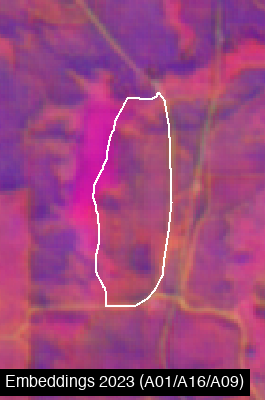

In [38]:
from gee_polygons.visualize import render_image

# Get embedding image for visualization
emb_image = get_embedding_image(site.geometry, 2023)

# Render with default band combination
img = render_image(
    image=emb_image,
    region=site.geometry.buffer(500).bounds(),
    vis_params=EMBEDDING_VIS_DEFAULT,
    dimensions=400,
    boundary=site.geometry,
    label='Embeddings 2023 (A01/A16/A09)'
)
img

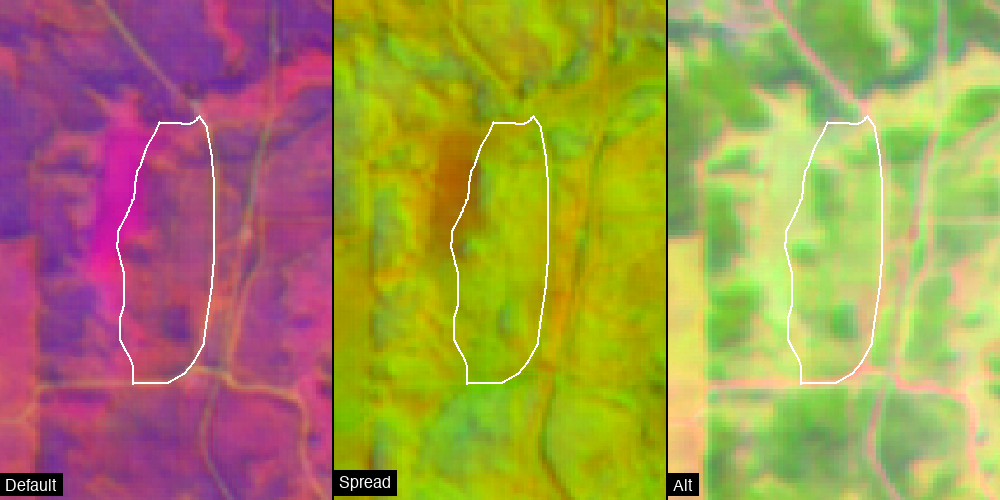

In [39]:
# Try different band combinations
from gee_polygons.visualize import export_frames_as_strip

band_combos = [
    (['A01', 'A16', 'A09'], 'Default'),
    (['A00', 'A32', 'A63'], 'Spread'),
    (['A05', 'A25', 'A45'], 'Alt'),
]

frames = []
for bands, name in band_combos:
    vis = {'min': -0.3, 'max': 0.3, 'bands': bands}
    frame = render_image(
        image=emb_image,
        region=site.geometry.buffer(500).bounds(),
        vis_params=vis,
        dimensions=500,
        boundary=site.geometry,
        label=name
    )
    frames.append(frame)

export_frames_as_strip(frames, '../outputs/embedding_band_combos.png')

from IPython.display import Image as IPImage
IPImage('../outputs/embedding_band_combos.png')

### Temporal Comparison

Compare embeddings across years to see how a site changes:

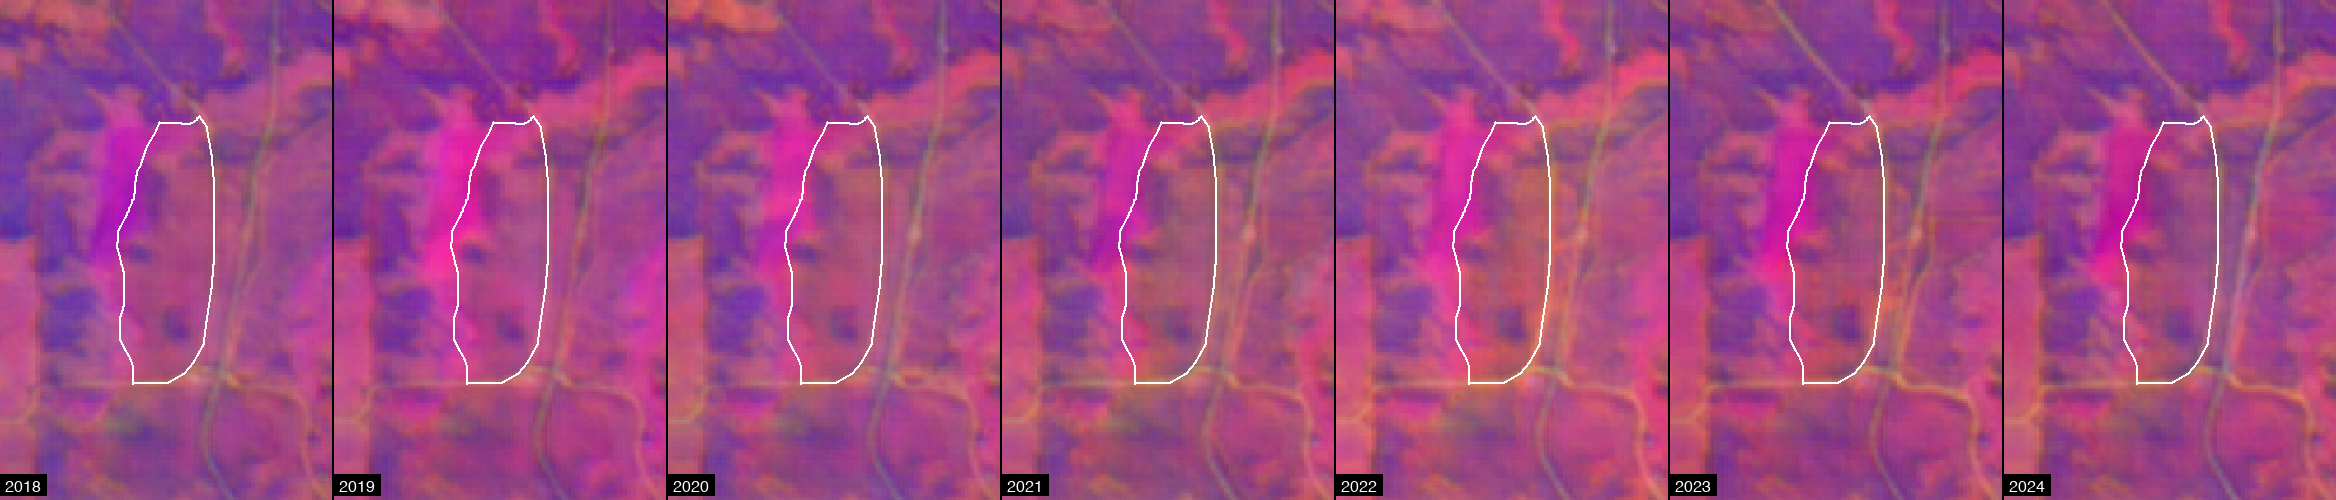

In [41]:
# Embedding timestrip 2018-2023
from gee_polygons.visualize import export_frames_as_gif

frames = []
for year in range(2018, 2025):
    emb_image = get_embedding_image(site.geometry, year)
    
    frame = render_image(
        image=emb_image,
        region=site.geometry.buffer(500).bounds(),
        vis_params=EMBEDDING_VIS_DEFAULT,
        dimensions=500,
        boundary=site.geometry,
        label=str(year)
    )
    frames.append(frame)

# Export as strip and GIF
export_frames_as_strip(frames, '../outputs/embedding_2018_2024.png')
export_frames_as_gif(frames, '../outputs/embedding_2018_2024.gif', duration_ms=700)

IPImage('../outputs/embedding_2018_2024.png')

### Advanced: Similarity Analysis

Since embeddings are unit vectors, you can compute cosine similarity between years:

In [42]:
import numpy as np

# Get embeddings for multiple years
df = site.extract_continuous(
    ALPHA_EMBEDDINGS,
    start_date='2018-01-01',
    end_date='2024-12-31',
    reducer='mean',
    frequency='yearly'
)

# Extract embedding vectors
years = df['year'].values
embeddings = df[EMBEDDING_BANDS].values

# Compute cosine similarity matrix
# Since vectors are unit length, cosine similarity = dot product
similarity_matrix = embeddings @ embeddings.T

print("Cosine similarity between years:")
import pandas as pd
sim_df = pd.DataFrame(similarity_matrix, index=years, columns=years)
sim_df.round(3)

Cosine similarity between years:


,2018,2019,2020,2021,2022,2023,2024
2018,0.920,0.902,0.910,0.897,0.883,0.898,0.887
2019,0.902,0.920,0.901,0.899,0.886,0.903,0.892
2020,0.910,0.901,0.921,0.907,0.897,0.907,0.895
2021,0.897,0.899,0.907,0.923,0.904,0.909,0.896
2022,0.883,0.886,0.897,0.904,0.906,0.900,0.886
2023,0.898,0.903,0.907,0.909,0.900,0.919,0.911
2024,0.887,0.892,0.895,0.896,0.886,0.911,0.917


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()